In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

import time
from glob import glob
from tqdm import tqdm
from permetrics.regression import RegressionMetric

import tensorflow as tf
import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import backend as K
from keras.utils import plot_model
from tensorflow.keras.layers import InputLayer

from keras.layers import Activation, Dense, LSTM, GRU, Bidirectional, AveragePooling1D, GlobalAveragePooling1D, Dropout, Flatten, BatchNormalization, TimeDistributed, Input, Reshape, RepeatVector, Concatenate, GlobalMaxPooling1D 
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from sklearn.metrics import r2_score

#GPU 자원이 부족
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [7]:
#최종 data 만들기
rawdata = pd.read_csv('data/rawdata_arima.csv', encoding = 'cp949')
rawdata

,Unnamed: 0,날짜,강수량(mm),방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,광진교_수위
0,0,2012-05-01 00:00:00,0.0,555.00,445.0,469.05,729.80,540.18,310.7,300.2,290.0,275.3,1.20
1,1,2012-05-01 00:10:00,0.0,562.90,449.0,498.00,731.48,540.18,314.7,300.2,290.0,275.3,1.20
2,2,2012-05-01 00:20:00,0.0,576.40,451.0,490.68,726.42,540.18,313.7,301.2,290.0,275.3,1.20
3,3,2012-05-01 00:30:00,0.0,563.10,452.0,476.21,726.42,552.17,311.7,301.2,290.0,276.3,1.20
4,4,2012-05-01 00:40:00,0.0,576.40,450.0,476.21,707.17,564.29,311.7,301.2,291.0,277.3,1.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,276331,2022-07-18 23:10:00,0.0,259.23,510.0,319.84,-456.41,974.40,0.0,0.0,0.0,0.0,1.12
276332,276332,2022-07-18 23:20:00,0.0,260.46,492.0,314.01,-717.30,1006.88,0.0,0.0,0.0,0.0,1.12
276333,276333,2022-07-18 23:30:00,0.0,259.37,475.0,387.55,-843.37,1039.90,0.0,0.0,0.0,0.0,1.12
276334,276334,2022-07-18 23:40:00,0.0,259.13,458.0,454.91,-1023.37,1073.46,0.0,0.0,0.0,0.0,1.12


In [8]:
방류량 = pd.read_csv('data/방류량.csv', encoding = 'cp949')
강화대교_조위 = pd.read_csv('data/강화대교_조위.csv', encoding = 'cp949')
청담대교_유량 = pd.read_csv('data/청담대교_유량.csv', encoding = 'cp949')
한강대교_유량 = pd.read_csv('data/한강대교_유량.csv', encoding = 'cp949')
행주대교_유량 = pd.read_csv('data/행주대교_유량.csv', encoding = 'cp949')
광진교_수위 = pd.read_csv('data/광진교_수위.csv', encoding = 'cp949')
수위 = pd.read_csv('data/수위x4.csv', encoding = 'cp949')

In [9]:
raw_data = pd.concat([rawdata[['강수량(mm)']],방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,광진교_수위,수위], axis = 1)
raw_data

,강수량(mm),방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,광진교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,0.0,555.00,445.0,469.05,729.80,540.18,1.20,310.7,300.2,290.0,275.3
1,0.0,562.90,449.0,498.00,731.48,540.18,1.20,314.7,300.2,290.0,275.3
2,0.0,576.40,451.0,490.68,726.42,540.18,1.20,313.7,301.2,290.0,275.3
3,0.0,563.10,452.0,476.21,726.42,552.17,1.20,311.7,301.2,290.0,276.3
4,0.0,576.40,450.0,476.21,707.17,564.29,1.20,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...
276331,0.0,259.23,510.0,319.84,-456.41,974.40,1.12,288.0,295.0,299.0,306.0
276332,0.0,260.46,492.0,314.01,-717.30,1006.88,1.12,287.0,303.0,304.0,308.0
276333,0.0,259.37,475.0,387.55,-843.37,1039.90,1.12,299.0,307.0,309.0,310.0
276334,0.0,259.13,458.0,454.91,-1023.37,1073.46,1.12,309.0,311.0,314.0,312.0


In [10]:
# x y 나누기
input_y = raw_data[['청담대교_수위','잠수교_수위','한강대교_수위','행주대교_수위']]
input_x = raw_data

# 정규화
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

input_x_regular = input_x.copy()

for i in range(len(input_x.columns)):
    scaler = MinMaxScaler()                       #StandardScaler() , MinMaxScaler() , RobustScaler()
    a=np.array(input_x_regular.iloc[:,i])
    tmp_x = scaler.fit_transform(a.reshape(-1,1))
    input_x_regular.iloc[:,i] = tmp_x

input_regular = pd.concat([input_x_regular, input_y], axis = 1)
input_regular

,강수량(mm),방류량,강화대교_조위,청담대교_유량,한강대교_유량,행주대교_유량,광진교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위,청담대교_수위,잠수교_수위,한강대교_수위,행주대교_수위
0,0.0,0.057689,0.374042,0.017323,0.147596,0.011070,0.056452,0.049611,0.060000,0.051621,0.056478,310.7,300.2,290.0,275.3
1,0.0,0.057984,0.377714,0.019365,0.147654,0.011070,0.056452,0.053502,0.060000,0.051621,0.056478,314.7,300.2,290.0,275.3
2,0.0,0.058488,0.379550,0.018849,0.147478,0.011070,0.056452,0.052529,0.061111,0.051621,0.056478,313.7,301.2,290.0,275.3
3,0.0,0.057992,0.380468,0.017828,0.147478,0.011475,0.056452,0.050584,0.061111,0.051621,0.058140,311.7,301.2,290.0,276.3
4,0.0,0.058488,0.378632,0.017828,0.146810,0.011883,0.056452,0.050584,0.061111,0.052821,0.059801,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,0.0,0.046645,0.433715,0.006797,0.106425,0.025719,0.045699,0.027529,0.054222,0.062425,0.107475,288.0,295.0,299.0,306.0
276332,0.0,0.046691,0.417190,0.006386,0.097370,0.026815,0.045699,0.026556,0.063111,0.068427,0.110797,287.0,303.0,304.0,308.0
276333,0.0,0.046650,0.401583,0.011574,0.092994,0.027929,0.045699,0.038230,0.067556,0.074430,0.114120,299.0,307.0,309.0,310.0
276334,0.0,0.046642,0.385976,0.016326,0.086747,0.029061,0.045699,0.047957,0.072000,0.080432,0.117442,309.0,311.0,314.0,312.0


# 모델1

In [16]:
## train / test data 생성

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-4,-3,-2,-1]
for i in range(len(input_regular.columns)-4):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

xdata_ = np.array(xdata)
ydata_ = np.array(ydata)

xtrain = xdata_[:-6912]
ytrain = ydata_[:-6912]
xtest = xdata_[-6912:]
ytest = ydata_[-6912:]

print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [01:46<00:00,  9.70s/it]


(269358, 6, 11)
(269358, 4)
(6912, 6, 11)
(6912, 4)


In [17]:
## 모델 정의

def nse(y_true, y_pred):
    return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

def root_mean_squared_error(y_true, y_pred):
    return (K.sqrt(K.mean(K.square(y_pred - y_true))))

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(InputLayer(input_shape=(w, xtrain.shape[2])))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(BatchNormalization())
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(GRU(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(GRU(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(GRU(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(4))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             1472      
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 384)           0         
 )                                                               
                                                                 
 gru (GRU)                   (None, 1, 200)            351600    
                                                                 
 gru_1 (GRU)                 (None, 1, 200)            241200    
                                                                 
 gru_2 (GRU)                 (None, 200)               241200    
                                                        

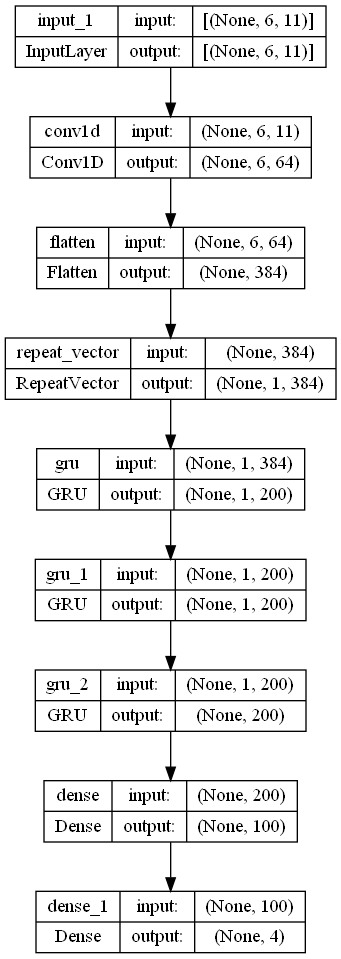

In [20]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [21]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

In [22]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])


Epoch 1/100
802/802 [==============================] - 19s 18ms/step - loss: 21.9964 - nse: 0.5562 - val_loss: 10.3133 - val_nse: 0.7699 - lr: 0.0100
Epoch 2/100
802/802 [==============================] - 15s 19ms/step - loss: 9.5897 - nse: 0.9594 - val_loss: 5.9845 - val_nse: 0.8956 - lr: 0.0100
Epoch 3/100
802/802 [==============================] - 15s 19ms/step - loss: 7.5165 - nse: 0.9790 - val_loss: 7.2076 - val_nse: 0.8487 - lr: 0.0100
Epoch 4/100
802/802 [==============================] - 14s 18ms/step - loss: 5.4839 - nse: 0.9880 - val_loss: 7.5001 - val_nse: 0.8545 - lr: 0.0100
Epoch 5/100
802/802 [==============================] - 17s 21ms/step - loss: 4.5548 - nse: 0.9920 - val_loss: 6.6510 - val_nse: 0.8760 - lr: 0.0100
Epoch 6/100
802/802 [==============================] - 16s 20ms/step - loss: 2.5917 - nse: 0.9977 - val_loss: 3.6283 - val_nse: 0.9614 - lr: 0.0050
Epoch 7/100
802/802 [==============================] - 17s 21ms/step - loss: 3.3185 - nse: 0.9960 - val_loss: 

In [25]:
## 평가
    
ytest_ = ytest
ytest = np.array(ytest).T

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})

yhat = keras_model_best.predict(xtest, verbose=1)

In [24]:
keras_model_best.evaluate(xtest,ytest_)

216/216 [==============================] - 2s 5ms/step - loss: 1.1155 - nse: 0.9910


[1.1154563426971436, 0.9910085201263428]

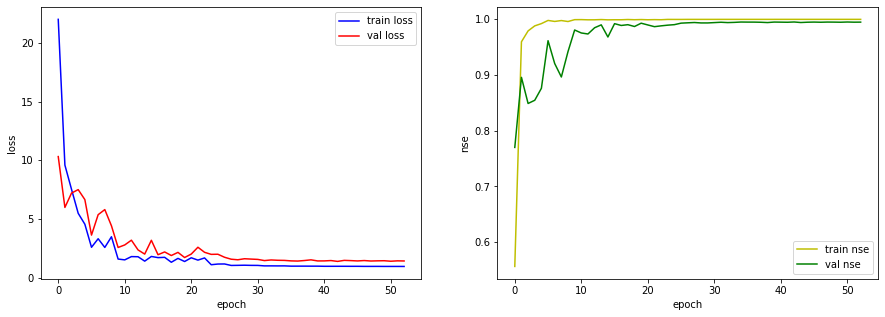

In [26]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

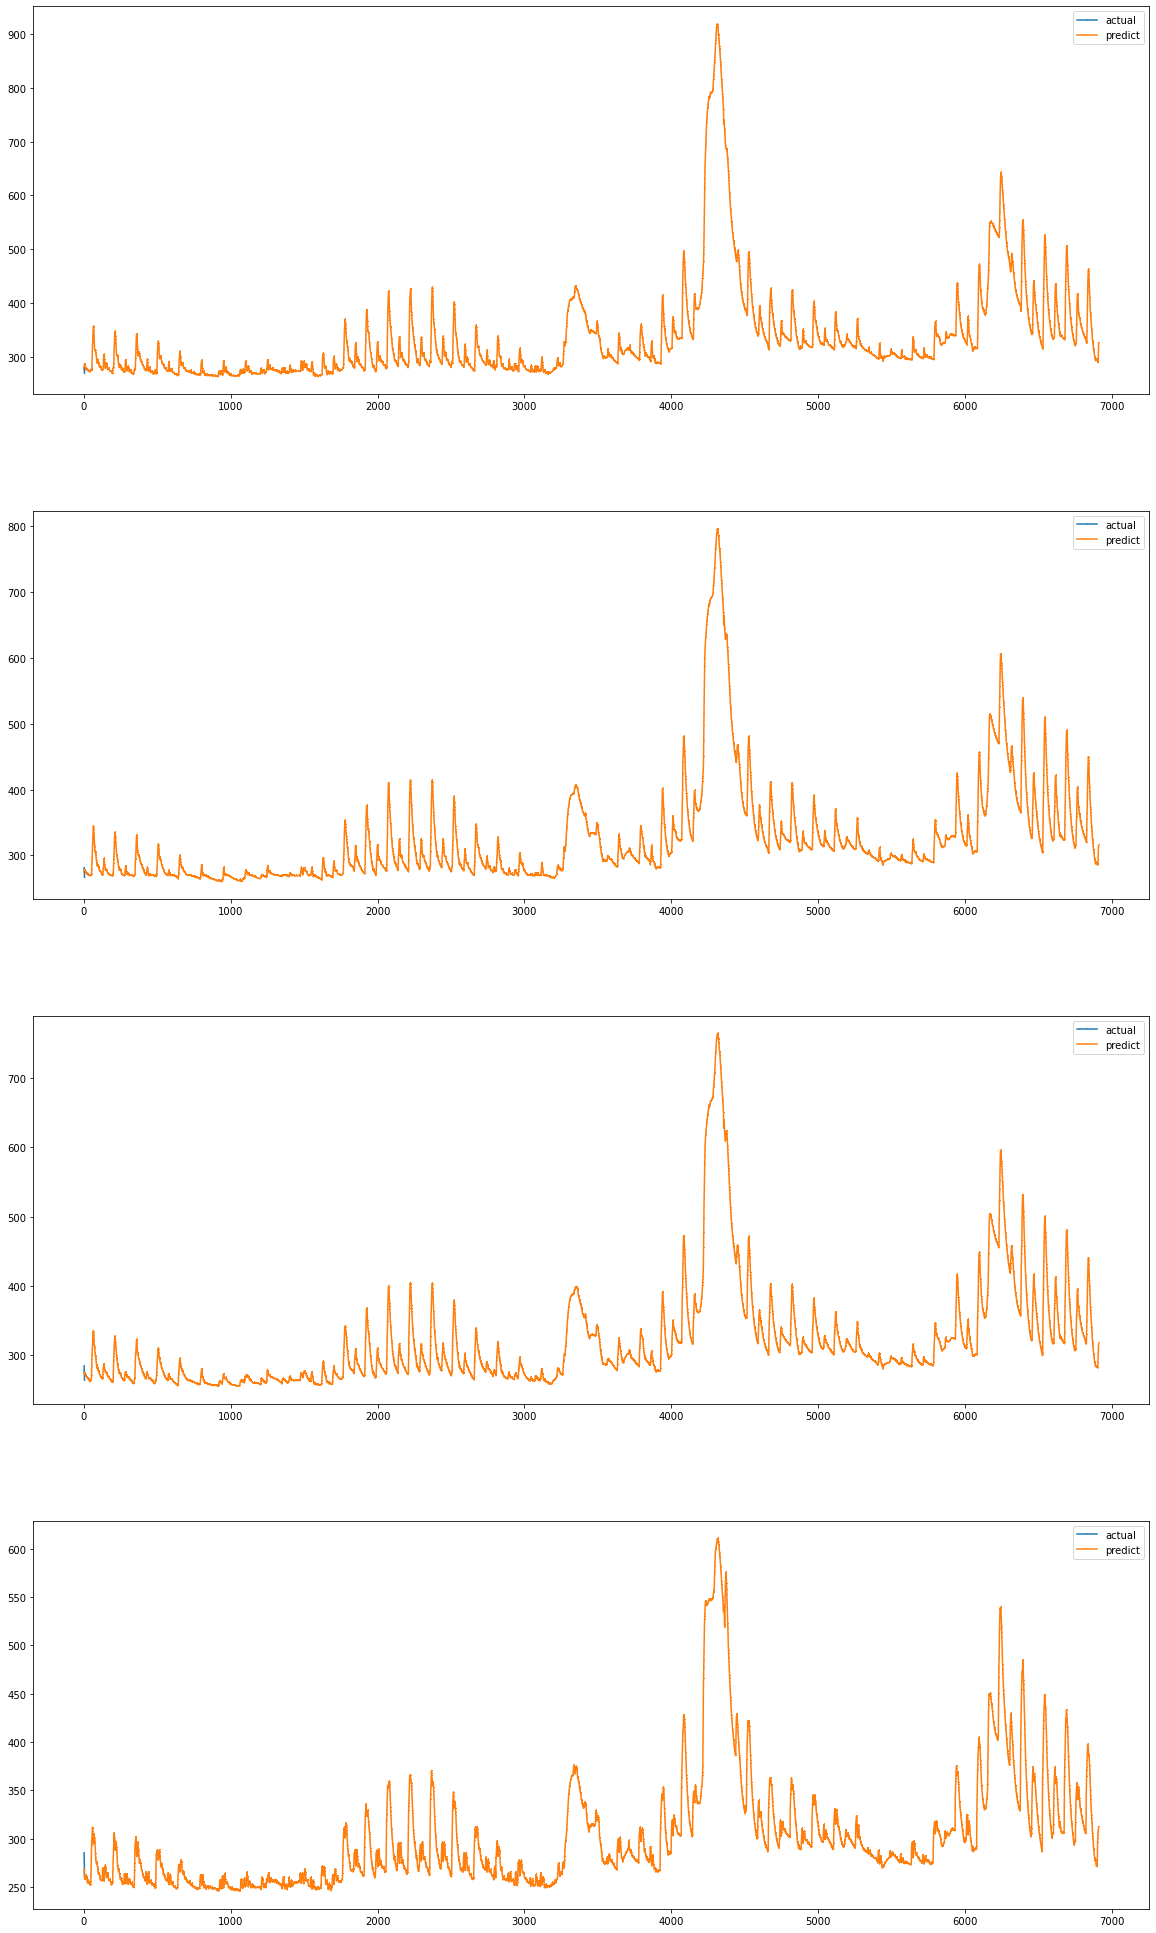

In [27]:
## 결과 시각화

tl_predict = np.array(yhat).T

f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest_[i], marker = ",", label = "actual")
    axes[i].plot(tl_predict[i], marker = ",", label="predict")
    axes[i].legend(prop={'size':10})  

plt.show()

In [29]:
## 점수 확인

score = []
for i in range(4):
    print(root_mean_squared_error(ytest[i], tl_predict[i])  / r2_score(ytest[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest[i], tl_predict[i]) / r2_score(ytest[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

tf.Tensor(1.5510745909561552, shape=(), dtype=float64)
tf.Tensor(0.8869856399087026, shape=(), dtype=float64)
tf.Tensor(1.233988336534318, shape=(), dtype=float64)
tf.Tensor(1.1653806842529704, shape=(), dtype=float64)
최종점수:  1.2093573129130366


In [30]:
## 파일 제출

sample_submission = pd.read_csv("data/sample_submission.csv")

sample_submission["wl_1018662"] = tl_predict[0]
sample_submission["wl_1018680"] = tl_predict[1]
sample_submission["wl_1018683"] = tl_predict[2]
sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("data/모델1.csv", index = False)

# 모델2

In [11]:
## train / test data 생성

xdata = []
ydata = []
xdata_idx = []
ydata_idx = [-4,-3,-2,-1]
for i in range(len(input_regular.columns)-4):
    xdata_idx.append(i)

w =  6 #window size

idx = []
for i in range(12):
  idx.append(i*26496)

for i in tqdm(range(11)):
    if i != 10:
        tmp = input_regular[idx[i]:idx[i+1]]
    else:
        tmp = input_regular[idx[i]:]

    for j in range(len(tmp)-w):
        xdata.append(np.array(tmp.iloc[j:j + w, xdata_idx]).astype(float))

    for j in range(w,len(tmp)):
        ydata.append(np.array(tmp.iloc[j, ydata_idx]).astype(float))

xdata_ = np.array(xdata)
ydata_ = np.array(ydata)

xtrain = xdata_[:-6912]
ytrain = ydata_[:-6912]
xtest = xdata_[-6912:]
ytest = ydata_[-6912:]

print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:47<00:00, 26.12s/it]


(269358, 6, 11)
(269358, 4)
(6912, 6, 11)
(6912, 4)


In [12]:
## 모델 정의

def nse(y_true, y_pred):
    return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

def root_mean_squared_error(y_true, y_pred):
    return (K.sqrt(K.mean(K.square(y_pred - y_true))))

if 'model_enc_dec_cnn' in locals(): 
    del model_enc_dec_cnn 
if 'history' in locals():
    del history

optimizer = tf.keras.optimizers.Adam(lr=0.01) #기본값 0.001

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(InputLayer(input_shape=(w, xtrain.shape[2])))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(BatchNormalization())
#model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=2, padding = 'causal', activation='relu'))
#model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())

model_enc_dec_cnn.add(RepeatVector(1))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
#model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(LSTM(200, activation='relu'))

model_enc_dec_cnn.add(Dense(100, activation='relu'))
model_enc_dec_cnn.add(Dense(4))

model_enc_dec_cnn.compile(loss=root_mean_squared_error, optimizer=optimizer, metrics =[nse])

model_enc_dec_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             1472      
                                                                 
 flatten (Flatten)           (None, 384)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 1, 384)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 1, 200)            468000    
                                                                 
 lstm_1 (LSTM)               (None, 1, 200)            320800    
                                                                 
 lstm_2 (LSTM)               (None, 200)               320800    
                                                      

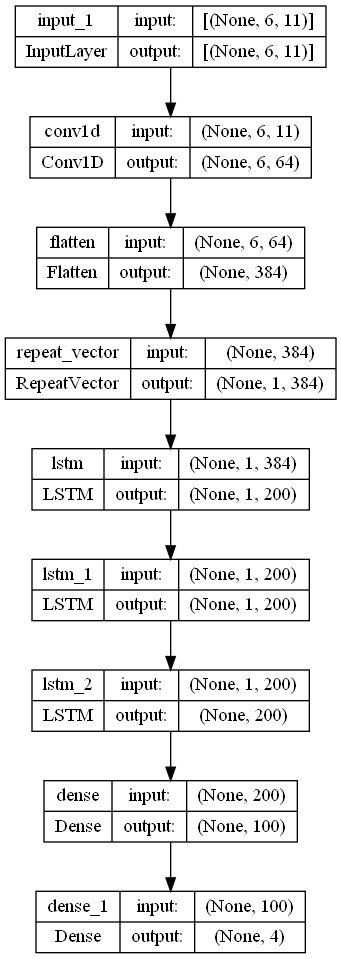

In [13]:
plot_model(model=model_enc_dec_cnn, show_shapes=True)

In [35]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

In [36]:
## 학습

history = model_enc_dec_cnn.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])


Epoch 1/100
802/802 [==============================] - 22s 23ms/step - loss: 26.7984 - nse: 0.1717 - val_loss: 35.0024 - val_nse: -2.1970 - lr: 0.0100
Epoch 2/100
802/802 [==============================] - 25s 31ms/step - loss: 11.8487 - nse: 0.9412 - val_loss: 14.5189 - val_nse: 0.4447 - lr: 0.0100
Epoch 3/100
802/802 [==============================] - 25s 31ms/step - loss: 9.2988 - nse: 0.9698 - val_loss: 10.5285 - val_nse: 0.7163 - lr: 0.0100
Epoch 4/100
802/802 [==============================] - 22s 27ms/step - loss: 8.0180 - nse: 0.9779 - val_loss: 11.1441 - val_nse: 0.6509 - lr: 0.0100
Epoch 5/100
802/802 [==============================] - 23s 29ms/step - loss: 5.5507 - nse: 0.9886 - val_loss: 7.8279 - val_nse: 0.8227 - lr: 0.0100
Epoch 6/100
802/802 [==============================] - 21s 26ms/step - loss: 4.6041 - nse: 0.9922 - val_loss: 9.2407 - val_nse: 0.7610 - lr: 0.0100
Epoch 7/100
802/802 [==============================] - 22s 28ms/step - loss: 5.6675 - nse: 0.9881 - val_l

In [37]:
## 평가
    
ytest_ = ytest
ytest = np.array(ytest).T

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})

yhat = keras_model_best.predict(xtest, verbose=1)

216/216 [==============================] - 2s 5ms/step


In [38]:
keras_model_best.evaluate(xtest,ytest_)

216/216 [==============================] - 2s 6ms/step - loss: 1.0836 - nse: 0.9917


[1.0835541486740112, 0.9916693568229675]

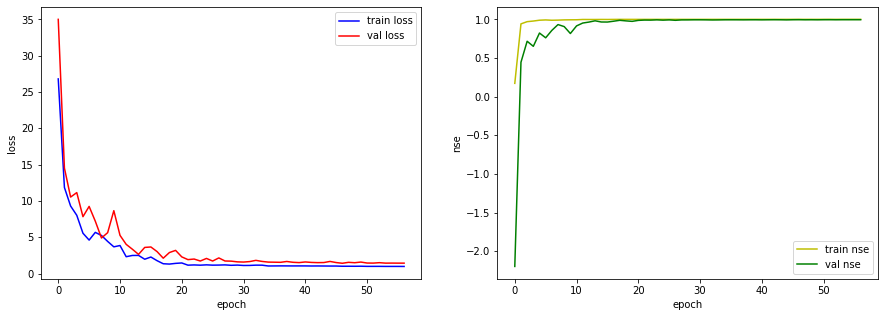

In [39]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

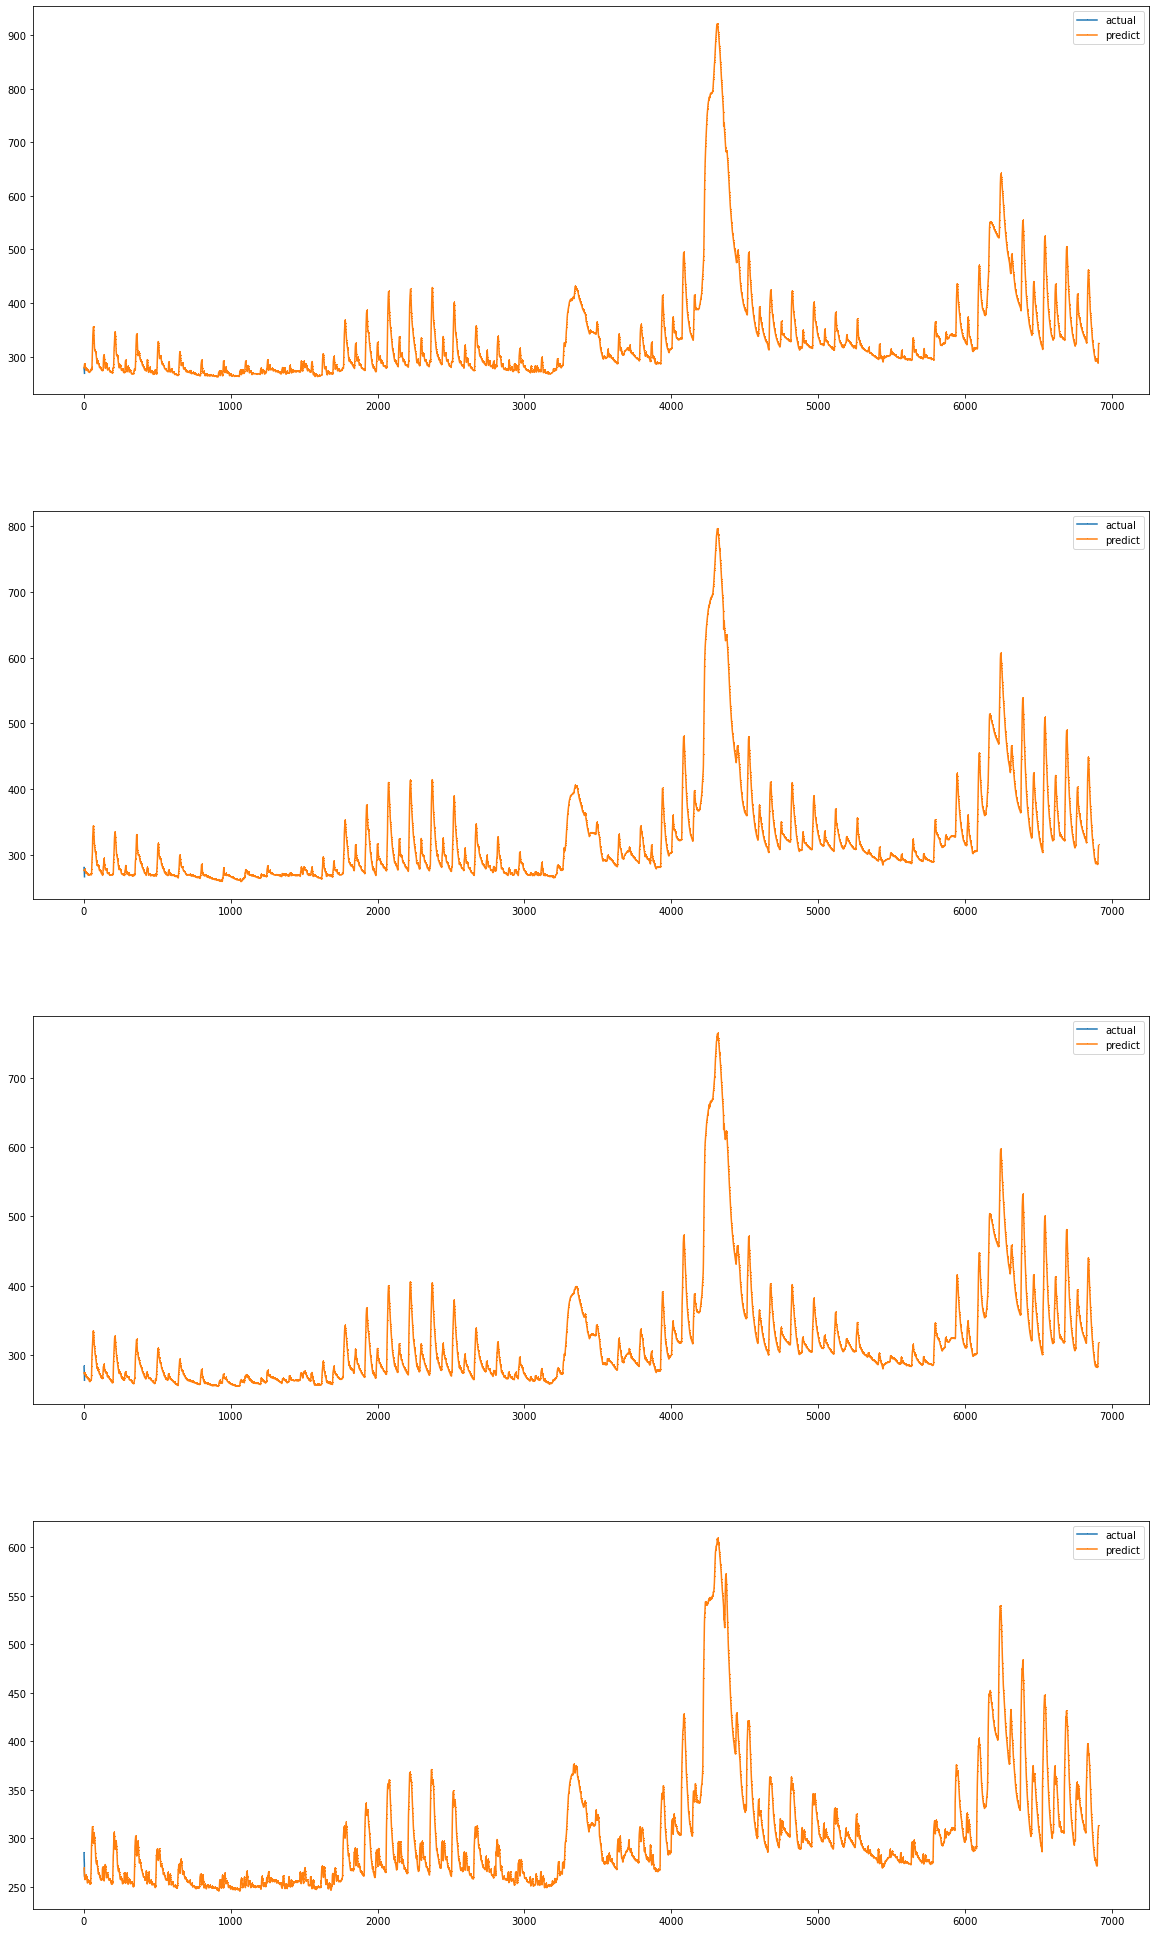

In [40]:
## 결과 시각화

tl_predict = np.array(yhat).T

f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest_[i], marker = ",", label = "actual")
    axes[i].plot(tl_predict[i], marker = ",", label="predict")
    axes[i].legend(prop={'size':10})  

plt.show()

In [41]:
## 점수 확인

score = []
for i in range(4):
    print(root_mean_squared_error(ytest[i], tl_predict[i])  / r2_score(ytest[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest[i], tl_predict[i]) / r2_score(ytest[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

tf.Tensor(1.4742357258682706, shape=(), dtype=float64)
tf.Tensor(0.937611540920727, shape=(), dtype=float64)
tf.Tensor(1.1455223993690564, shape=(), dtype=float64)
tf.Tensor(1.1635283214607617, shape=(), dtype=float64)
최종점수:  1.1802244969047038


In [42]:
## 파일 제출

sample_submission = pd.read_csv("data/sample_submission.csv")

sample_submission["wl_1018662"] = tl_predict[0]
sample_submission["wl_1018680"] = tl_predict[1]
sample_submission["wl_1018683"] = tl_predict[2]
sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("data/모델2.csv", index = False)

# 모델3

In [45]:
xdata_ = np.array(input_x_regular)
ydata_ = np.array(input_y)

xtrain = xdata_[:-6912]
ytrain = ydata_[:-6912]
xtest = xdata_[-6912:]
ytest = ydata_[-6912:]

  
ytest_ = ytest
ytest = np.array(ytest)

In [46]:
xtrain = np.expand_dims(xtrain, axis=2)
xtest = np.expand_dims(xtest, axis=2)

print(xtrain.shape)
print(xtest.shape)
print(ytrain.shape)
print(ytest.shape)

(269424, 11, 1)
(6912, 11, 1)
(269424, 4)
(6912, 4)


In [47]:
if 'Model' in locals(): 
    del Model 
if 'history' in locals():
    del history

In [48]:
## 모델 정의

# VGG 1D-Convolution Architecture in Keras - For both Classification and Regression Problems
"""Reference: [Very Deep Convolutional Networks for Large-Scale Image Recognition] (https://arxiv.org/abs/1409.1556)"""


import tensorflow as tf


def Conv_1D_Block(x, model_width, kernel):
    # 1D Convolutional Block with BatchNormalization
    x = tf.keras.layers.Conv1D(model_width, kernel, padding='same', kernel_initializer="he_normal")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    return x


class VGG:
    def __init__(self, length, num_channel, num_filters, problem_type='Regression', output_nums=1, dropout_rate=False):
        self.length = length
        self.num_channel = num_channel
        self.num_filters = num_filters
        self.problem_type = problem_type
        self.output_nums = output_nums
        self.dropout_rate = dropout_rate

    def VGG11(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        # Block 1
        x = Conv_1D_Block(inputs, self.num_filters * (2 ** 0), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 2
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 3
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 4
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 5
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Fully Connected (MLP) block
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dense(2048, activation='relu')(x)
        x = tf.keras.layers.Dense(2048, activation='relu')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        # Create model.
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        return model

    def VGG13(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        # Block 1
        x = Conv_1D_Block(inputs, self.num_filters * (2 ** 0), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 0), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 2
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 3
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 4
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 5
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Fully Connected (MLP) block
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        # Create model.
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        return model

    def VGG16(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        # Block 1
        x = Conv_1D_Block(inputs, self.num_filters * (2 ** 0), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 0), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 2
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 3
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 4
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 5
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Fully Connected (MLP) block
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        # Create model.
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        return model

    def VGG16_v2(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        # Block 1
        x = Conv_1D_Block(inputs, self.num_filters * (2 ** 0), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 0), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 2
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 3
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 1)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 4
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 1)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 5
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 1)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Fully Connected (MLP) block
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        x = tf.keras.layers.Dense(4096, activation='relu')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        # Create model.
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        return model

    def VGG19(self):
        inputs = tf.keras.Input((self.length, self.num_channel))  # The input tensor
        #input_shape=(w, xtrain.shape[2])
        # Block 1
        x = Conv_1D_Block(inputs, self.num_filters * (2 ** 0), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 0), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 2
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 1), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 3
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 2), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 4
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Block 5
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        x = Conv_1D_Block(x, self.num_filters * (2 ** 3), 3)
        if x.shape[1] <= 2:
            x = tf.keras.layers.MaxPooling1D(pool_size=1, strides=2, padding="valid")(x)
        else:
            x = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2, padding="valid")(x)

        # Fully Connected (MLP) block
        x = tf.keras.layers.Flatten(name='flatten')(x)
        x = tf.keras.layers.Dense(2048, activation='relu')(x)
        x = tf.keras.layers.Dense(2048, activation='relu')(x)
        if self.dropout_rate:
            x = tf.keras.layers.Dropout(self.dropout_rate, name='Dropout')(x)
        outputs = tf.keras.layers.Dense(self.output_nums, activation='linear')(x)
        if self.problem_type == 'Classification':
            outputs = tf.keras.layers.Dense(self.output_nums, activation='softmax')(x)

        # Create model.
        model = tf.keras.Model(inputs=inputs, outputs=outputs)

        return model


if __name__ == '__main__':
    # Configurations
    length = xtrain.shape[1]  # Length of each Segment
    model_name = 'VGG19'  # DenseNet Models
    model_width = 16 # Width of the Initial Layer, subsequent layers start from here
    num_channel = 1  # Number of Input Channels in the Model
    problem_type = 'Regression' # Classification or Regression
    output_nums = 4  # Number of Class for Classification Problems, always '1' for Regression Problems
    
    def nse(y_true, y_pred):
        return (1-(K.sum((y_true-y_pred)**2)/K.sum((y_true-K.mean(y_true))**2)))

    def root_mean_squared_error(y_true, y_pred):
        return (K.sqrt(K.mean(K.square(y_pred - y_true))))

    #
    Model = VGG(length, num_channel, model_width, problem_type=problem_type, output_nums=output_nums, dropout_rate=False).VGG11()
    Model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss=root_mean_squared_error, metrics=[nse])
    Model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 11, 1)]           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 11, 16)            64        
                                                                 
 batch_normalization (BatchN  (None, 11, 16)           64        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 11, 16)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 5, 16)            0         
 )                                                               
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 32)             1568  

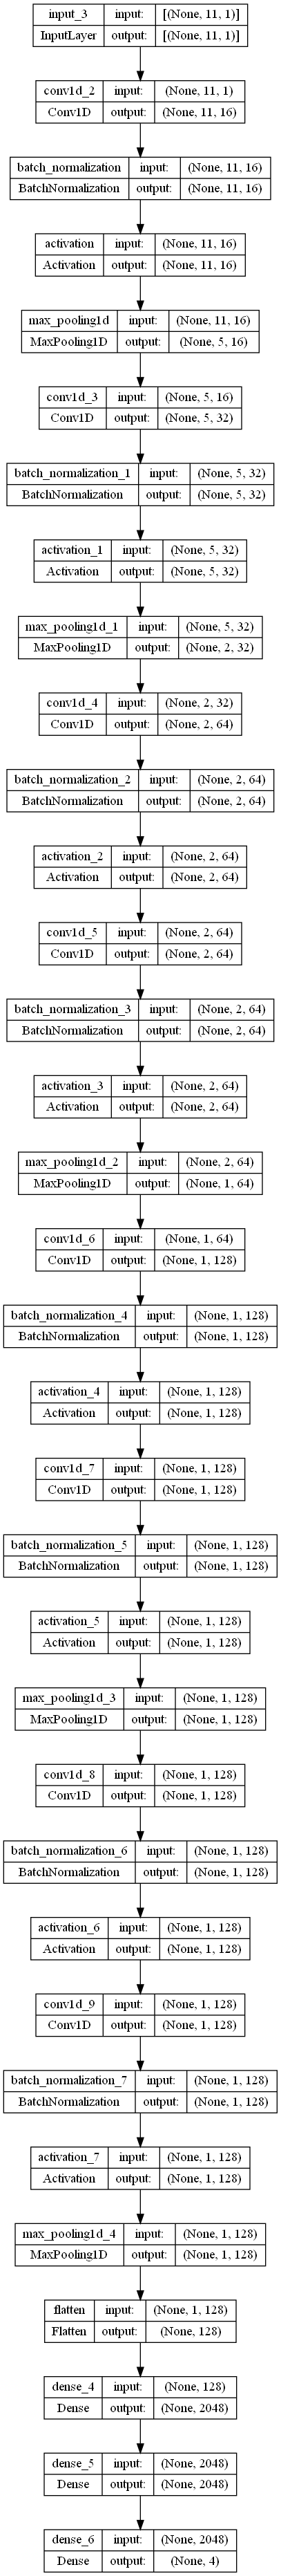

In [49]:
plot_model(model=Model, show_shapes=True)

In [50]:
epochs = 100
batch_size = xtrain.shape[0] // 1000
validation = 0.2

checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=False, monitor='val_loss',
                                         mode='min', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.005, patience=10, mode='min')
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, mode='min', patience=3, min_lr=1e-10)

In [51]:
## 학습

history = Model.fit(xtrain, ytrain, verbose=1, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])

Epoch 1/100
802/802 [==============================] - 49s 57ms/step - loss: 21.3662 - nse: 0.0820 - val_loss: 16.9350 - val_nse: 0.0423 - lr: 3.0000e-04
Epoch 2/100
802/802 [==============================] - 59s 73ms/step - loss: 7.6145 - nse: 0.9796 - val_loss: 9.1723 - val_nse: 0.7856 - lr: 3.0000e-04
Epoch 3/100
802/802 [==============================] - 59s 74ms/step - loss: 6.6743 - nse: 0.9841 - val_loss: 10.0112 - val_nse: 0.6366 - lr: 3.0000e-04
Epoch 4/100
802/802 [==============================] - 59s 74ms/step - loss: 6.2631 - nse: 0.9859 - val_loss: 9.0119 - val_nse: 0.7836 - lr: 3.0000e-04
Epoch 5/100
802/802 [==============================] - 60s 74ms/step - loss: 5.6646 - nse: 0.9886 - val_loss: 7.2491 - val_nse: 0.8557 - lr: 3.0000e-04
Epoch 6/100
802/802 [==============================] - 59s 74ms/step - loss: 5.0920 - nse: 0.9908 - val_loss: 7.1088 - val_nse: 0.8513 - lr: 3.0000e-04
Epoch 7/100
802/802 [==============================] - 58s 73ms/step - loss: 4.9678 -

In [52]:
## 평가

keras_model_best = keras.models.load_model('best_model.h5', custom_objects={'root_mean_squared_error': root_mean_squared_error, 'nse': nse})

yhat = keras_model_best.predict(xtest, verbose=1)

keras_model_best.evaluate(xtest,ytest)

216/216 [==============================] - 3s 12ms/step - loss: 2.3395 - nse: 0.9582


[2.3394901752471924, 0.9582248330116272]

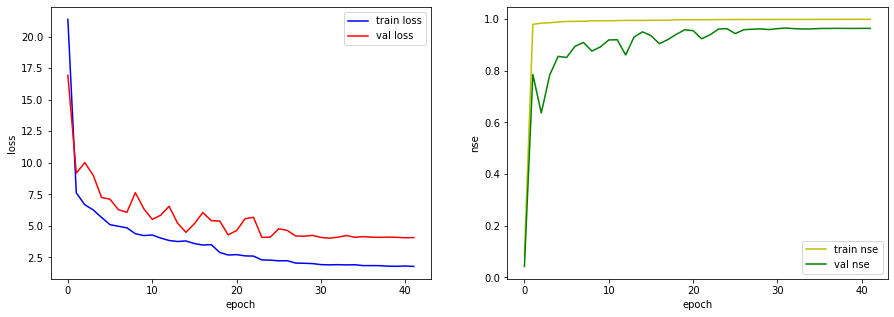

In [53]:
## 학습 과정 시각화

fig, loss_ax = plt.subplots(1, 2)
fig.set_size_inches((15,5))

loss_ax[0].plot(history.history['loss'], 'b', label='train loss')
loss_ax[0].plot(history.history['val_loss'], 'r', label='val loss')

loss_ax[1].plot(history.history['nse'], 'y', label='train nse')
loss_ax[1].plot(history.history['val_nse'], 'g', label='val nse')

loss_ax[0].set_xlabel('epoch')
loss_ax[0].set_ylabel('loss')
loss_ax[1].set_xlabel('epoch')
loss_ax[1].set_ylabel('nse')

loss_ax[0].legend(loc='upper right')
loss_ax[1].legend(loc='lower right')

plt.show()

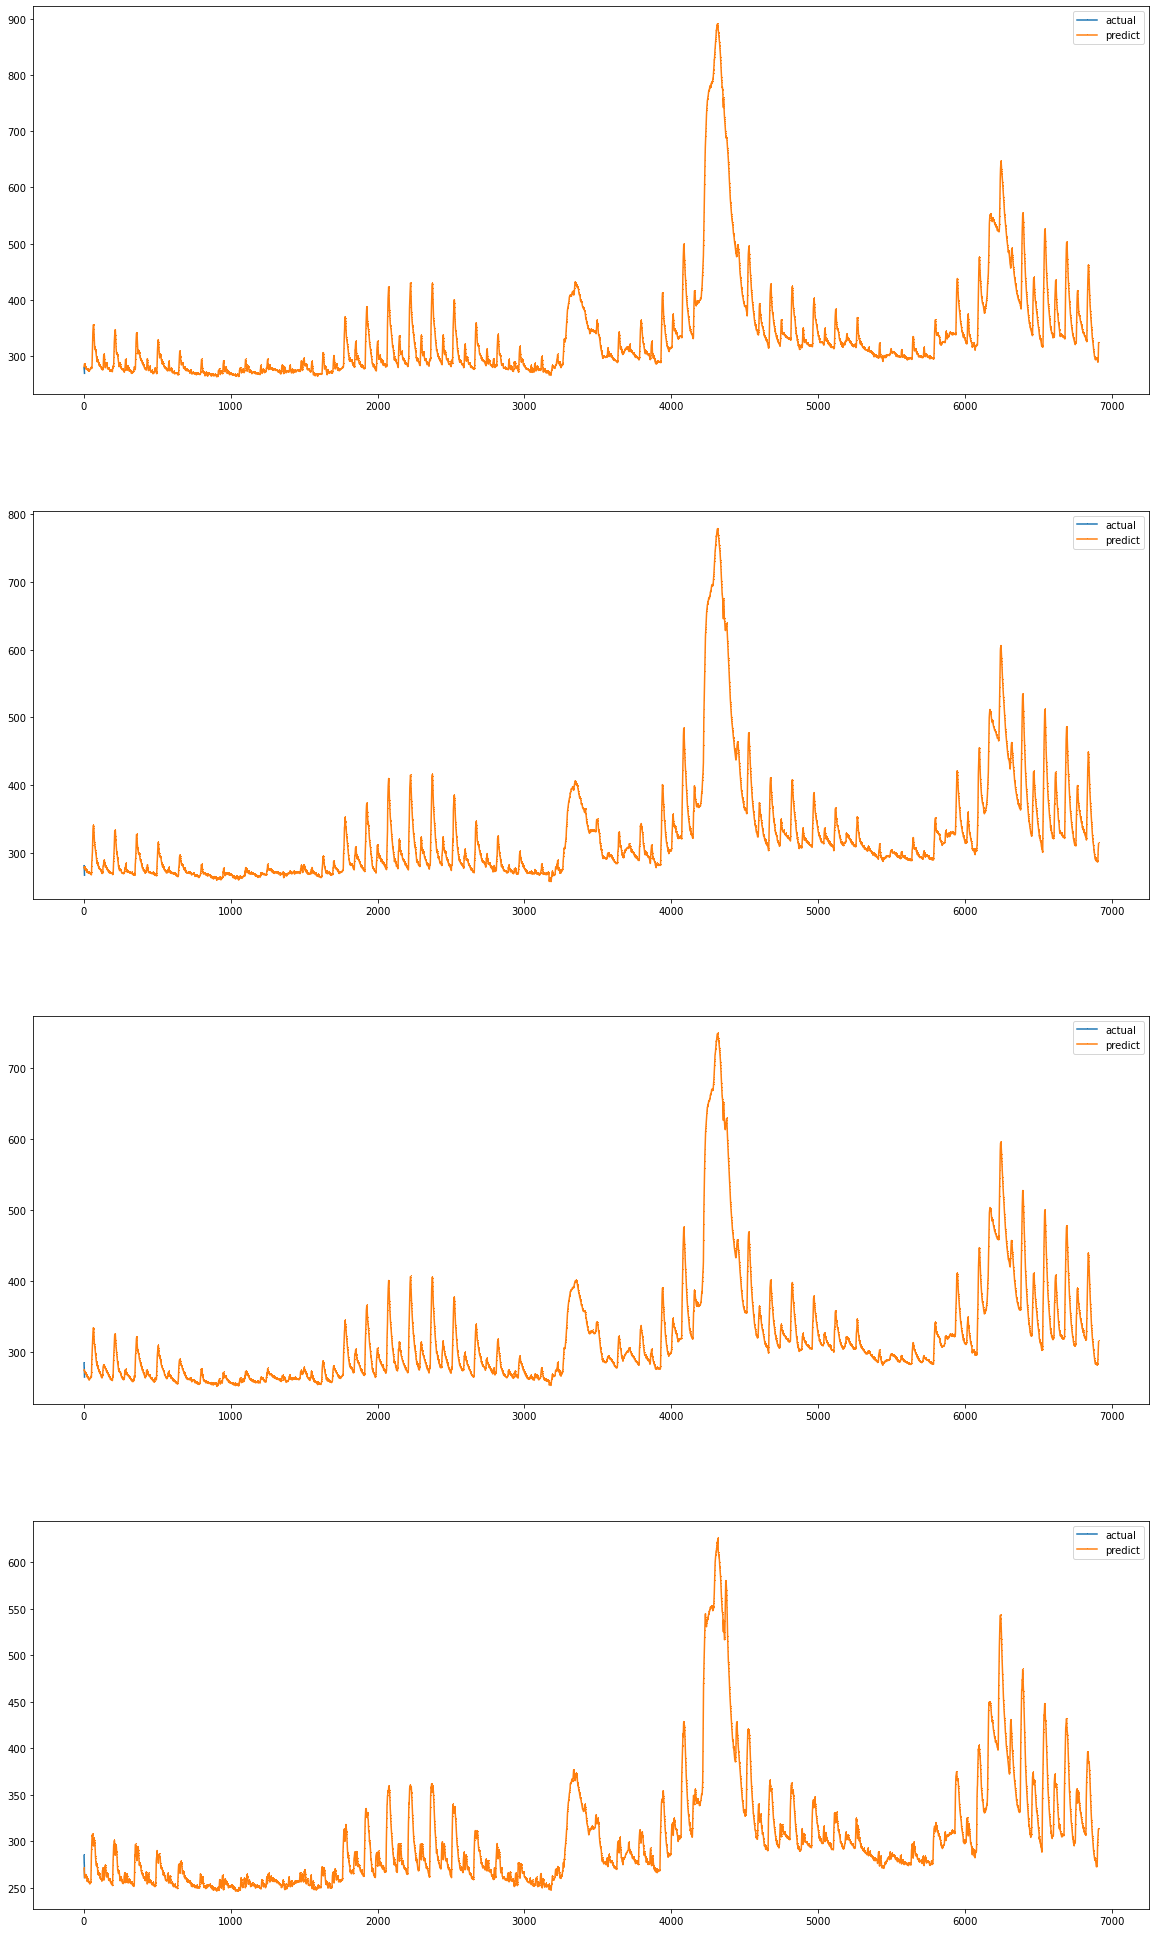

In [54]:
## 결과 시각화

tl_predict = np.array(yhat).T

f, axes = plt.subplots(4, 1)
f.set_size_inches((20, 35))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

for i in range(4):
    axes[i].plot(ytest_[i], marker = ",", label = "actual")
    axes[i].plot(tl_predict[i], marker = ",", label="predict")
    axes[i].legend(prop={'size':10})  

plt.show()

In [58]:
## 점수 확인

score = []
for i in range(4):
    print(root_mean_squared_error(ytest.T[i], tl_predict[i])  / r2_score(ytest.T[i], tl_predict[i]))
    score.append(root_mean_squared_error(ytest.T[i], tl_predict[i]) / r2_score(ytest.T[i], tl_predict[i]))
    
print("최종점수: ", np.mean(score))

tf.Tensor(3.311966524327133, shape=(), dtype=float64)
tf.Tensor(2.6634783261044217, shape=(), dtype=float64)
tf.Tensor(3.045044433702971, shape=(), dtype=float64)
tf.Tensor(2.2276893229454076, shape=(), dtype=float64)
최종점수:  2.812044651769983


In [59]:
## 파일 제출

sample_submission = pd.read_csv("data/sample_submission.csv")

sample_submission["wl_1018662"] = tl_predict[0]
sample_submission["wl_1018680"] = tl_predict[1]
sample_submission["wl_1018683"] = tl_predict[2]
sample_submission["wl_1019630"] = tl_predict[3]

sample_submission.to_csv("data/모델3.csv", index = False)

# 제출 파일 만들기

In [3]:
모델1 = pd.read_csv('data/모델1.csv', usecols=[0,2])
모델2 = pd.read_csv('data/모델2.csv', usecols=[1,3,4])

wl_1018662 = pd.read_csv('data/모델2.csv', usecols=[0,1])
wl_1018680 = pd.read_csv('data/모델1.csv', usecols=[2])
wl_1018683 = pd.read_csv('data/모델2.csv', usecols=[3])
wl_1019630 = pd.read_csv('data/모델2.csv', usecols=[4])

result = pd.concat([wl_1018662, wl_1018680, wl_1018683, wl_1019630], axis = 1)
result

,ymdhm,wl_1018662,wl_1018680,wl_1018683,wl_1019630
0,2022-06-01 00:00,279.44876,276.80942,274.67114,269.06647
1,2022-06-01 00:10,281.57523,276.64807,273.45074,267.30130
2,2022-06-01 00:20,283.48062,276.93167,273.04303,264.46356
3,2022-06-01 00:30,285.90494,277.53490,273.38132,261.82635
4,2022-06-01 00:40,286.83914,277.85806,273.73245,259.13718
...,...,...,...,...,...
6907,2022-07-18 23:10,288.88568,293.17804,298.14000,306.38776
6908,2022-07-18 23:20,287.80862,302.19064,304.88324,308.24326
6909,2022-07-18 23:30,297.68588,306.62380,307.54883,309.24930
6910,2022-07-18 23:40,309.53378,311.53574,311.78262,311.32123


In [5]:
result.to_csv('data/최종제출파일.csv', index = False)